Poincare plots (Wendelstein 7-X)
================================

This example shows how to create Poincare plots for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard() + w7x.controlCoils([2000, 2000])
geometry = w7x.op21Geometry()

grid = w7x.defaultGrid()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

field = field.compute(grid)

C:\Daten\repos\fsc\src\python\fusionsc\wrappers.py:144: UserWarning: The function fusionsc.devices.w7x.defaultGrid is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")


Finally, we need to decide in which phi planes we want to evaluate our Poincare plots, and which points to start our traces on.

In [4]:
import numpy as np
phiPlanes = np.linspace(0, 2 / 5 * np.pi, 6, endpoint = False)

# Put more starting points inside the island
rStart = np.concatenate([
    np.linspace(4.5, 4.8, 10, endpoint = False),
    np.linspace(4.8, 5.4, 10)
])
phiStart = np.linspace(0, 2 * np.pi, 5, endpoint = False) + np.pi

# Starting on an r, phi grid allows us to see all 5 islands
rStartG, phiStartG = np.meshgrid(rStart, phiStart, indexing = 'ij')

xStart = rStartG * np.cos(phiStartG)
yStart = rStartG * np.sin(phiStartG)
zStart = 0 * rStartG

startPoints = [xStart, yStart, zStart]

Now it's time to run our calculation.

In [5]:
pcPoints = fsc.flt.poincareInPhiPlanes(
    startPoints, field, phiPlanes, 200,
    grid = grid,
    geometry = geometry, geometryGrid = w7x.defaultGeometryGrid(),
    distanceLimit = 1e4,
    
    targetError = 1e-4, maxStepSize = 0.2,
)

C:\Daten\repos\fsc\src\python\fusionsc\wrappers.py:144: UserWarning: The function fusionsc.devices.w7x.defaultGeometryGrid is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")


The calculation returns a numpy array with a specific shape:
- The first dimension of the array is always 5. The first 3 entries are the x, y, z positions of the intersection points, while the other 2 are forward and backward connection-lengths. Negative values indicate, that the respective length (given by the absolute value) is given by something other than a collision event (start point, tracing limit, leaving the grid, etc.)
- The second dimension corresponds to the selected phi values to do the intersection at.
- The third dimension on corresponds to the dimensions of the starting point array (excluding its first xyz dimension)
- Finally, the last dimension corresponds to the turn counter of the field line.

In [6]:
# Shape is [5, nPlanes] + startsPoints.shape[1:] + [nTurns]
pcPoints.shape

(5, 6, 20, 5, 200)

We can now plot each series of intersection points. For this, we can also make use of the fsc.geometry.plotCut function, which will compute phi slices of the geometry.

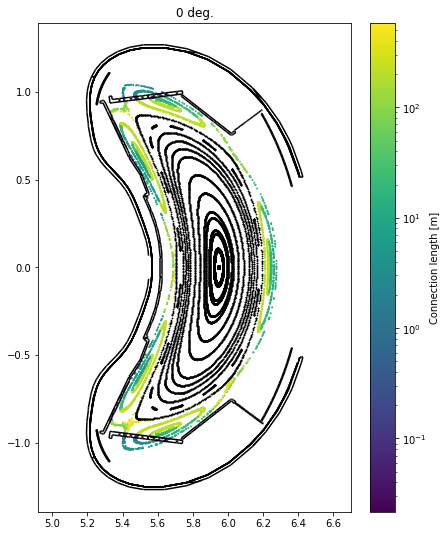

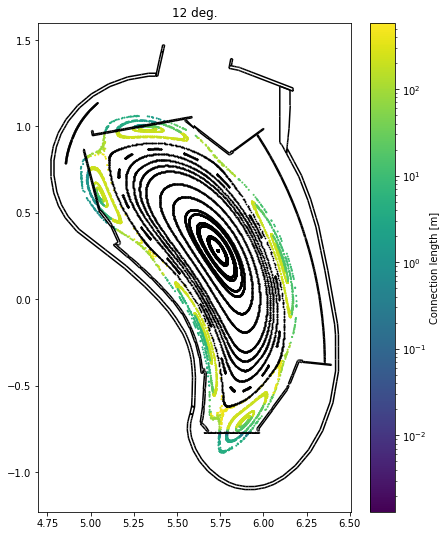

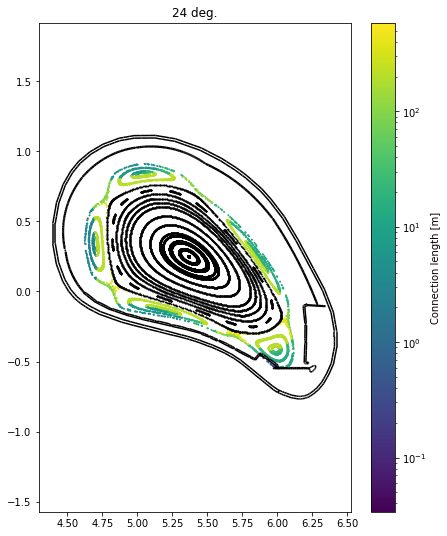

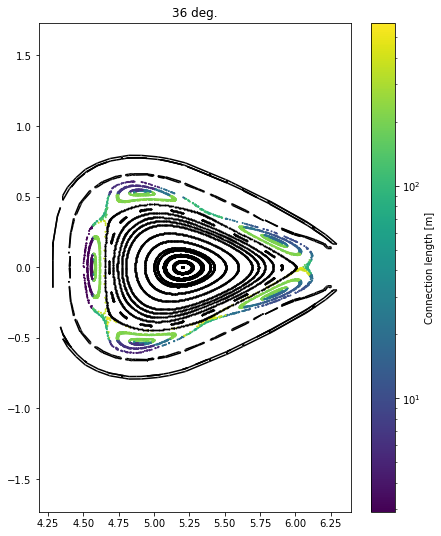

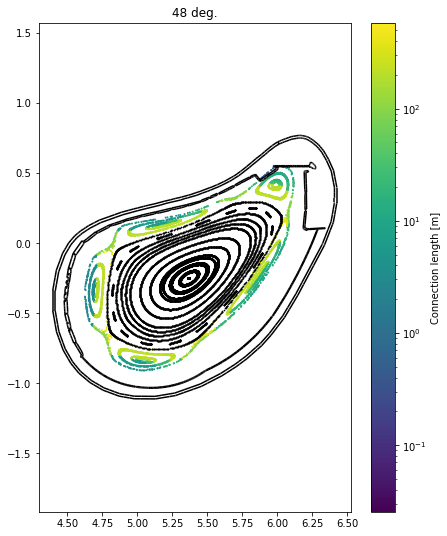

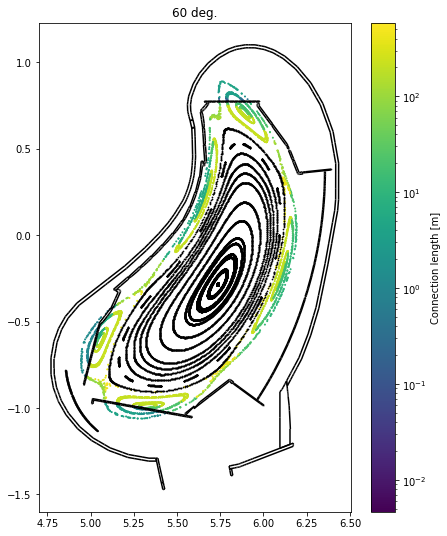

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

for iPhi, phi in enumerate(phiPlanes):
    x, y, z, cLenF, cLenB = pcPoints[:, iPhi, :, :].reshape([5, -1])
    r = np.sqrt(x**2 + y**2)
    
    # Negative connection lengths indicate that the line segment going through
    # the point in that direction is not terminated by collision (e.g. it left
    # the grid or hit the distance limit)
    mask = np.logical_and(cLenF > 0, cLenB > 0)
    mask2 = np.logical_and(cLenF < 0, cLenB < 0)
    
    cLen = cLenF + cLenB
    
    plt.figure(figsize = (7, 9))
    plt.title('{:.0f} deg.'.format(np.degrees(phi)))
    plt.scatter(r[mask], z[mask], c = cLen[mask], norm = matplotlib.colors.LogNorm(), s = 1)
    plt.colorbar(label = 'Connection length [m]')
    plt.scatter(r[mask2], z[mask2], c = 'k', s = 0.5)
    
    geometry.plotCut(phi, edgecolors = 'k')
    plt.axis('equal')